In [1]:
!export PYTHONPATH=/usr/project/xtmp/sk787/variable_imp_matching/

In [2]:
import sys
sys.path.append('/usr/project/xtmp/sk787/variable_imp_matching/')
sys.path.insert(0, '/usr/project/xtmp/sk787/variable_imp_matching/')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
# from datagen.dgp_df import dgp_poly_basic_df, dgp_df
from src.variable_imp_matching import VIM
from scipy.spatial.distance import pdist
import warnings
from utils import save_df_to_csv
from collections import namedtuple
from argparse import ArgumentParser
from econml.dml import CausalForestDML, KernelDML
from econml.dr import DRLearner
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from tqdm import tqdm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
import numpy as np
# from datagen.dgp_df import dgp_df
from variance_playground import *
from src.variable_imp_matching import VIM

In [23]:
from sklearn.preprocessing import StandardScaler, minmax_scale
def linear_outcome(X, T):
    n_samples = X.shape[0]
    coef = np.array(list(range(2)) + [0] * (X.shape[1] - 2))
    Y0_true = X.dot(coef).reshape(-1,1)
    Y1_true = Y0_true + 1 + X.dot(coef).reshape(-1,1)
    error = np.random.uniform(-1, 1, size = (n_samples, 1))
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true
    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true

def add_noise(X, heteroskedasticity):
    if type(X) is not np.ndarray:
        X = np.array(X)
    error = np.random.uniform(-1, 1, size = (X.shape[0], 1))
    if heteroskedasticity:
        error * np.log(X[:, 0]**2 + 1).reshape(-1,1)
    return error

def dgp_linear(n_unimp, n_samples):
    n_imp = 2
    xmin = 0
    xmax = 5
    X = np.random.uniform(xmin, xmax, size = [n_samples, n_imp + n_unimp])
    T = np.random.binomial(n = 1, p = minmax_scale(X[:,0] + 3 * X[:, 1], feature_range=(0.25, 0.75))).reshape(-1,1)
    coef = np.array(list(range(n_imp)) + [0] * n_unimp)
    Y0_true = X.dot(coef).reshape(-1,1)
    Y1_true = 2 * Y0_true + 1
    error = add_noise(X, 0) # np.random.uniform(-1, 1, size = (n_samples, 1))
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true
    # min is just smallest y0 == min(y0_true) - 1 == 0 - 1 = -1
    ymin = np.array([xmin] * (n_imp + n_unimp)).dot(coef) - 1 # substract error as well
    # max is largest y1 == max(y1_true) + error == max(2 * y0_true + 1) + error = 2 * max(y0_true) + 1 + 1
    ymax = 2 * np.array([xmax] * (n_imp + n_unimp)).dot(coef) + 2 # add error as well
    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax

def dgp_lihua(n_unimp, n_samples, corr, heteroskedasticity):
    n_imp = 2
    mean = np.array([0] * (n_imp + n_unimp))
    cov = np.ones(shape = [n_imp + n_unimp, n_imp + n_unimp]) * corr
    np.fill_diagonal(cov, np.repeat(a = 1, repeats=n_imp + n_unimp))
    X = np.random.multivariate_normal(mean, cov, size = n_samples)
    xmax = 5
    xmin = -5
    X[X > xmax] = xmax
    X[X < xmin] = xmin
    
    import scipy.stats as stats
    T = np.random.binomial(n = 1, p = stats.beta.cdf(x = X[:, 0], a = 2, b = 4)).reshape(-1,1)
    def f(X): # bounded by [0,2]
        return 2/(1 + np.exp(-12 * (X - 0.5)))
    Y0_true = (np.array([0] * n_samples)).reshape(-1,1)
    Y1_true = (f(X[:, 0]) * f(X[:, 1])).reshape(-1,1)
    max_error = 1
    min_error = -1
    
    error = add_noise(X, heteroskedasticity=heteroskedasticity)
    
    if heteroskedasticity:
        max_error = max_error * np.log(np.max(np.abs([xmax, xmin]))**2 + 1)
        min_error = min_error * np.log(np.min(np.abs([xmax, xmin]))**2 + 1)
    
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true

    # ymax = max(y1_true + error) = max(y1_true) + max(error) = max(f(\cdot)) * max(f(\cdot)) + max(error) = 2 * 2 + max(error) 
    ymax = 4 + max_error
    # ymin = min(y1_true + error, y0_true + error) = min(sigmoid(\cdot) + error, 0 + error) = min(0 + error, 0 + error) = min(error)
    ymin = min_error

    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax


def dgp_df(dgp, n_samples, n_imp = None, n_unimp=None, perc_train=None, n_train=None, X = None, data_seed = 42, coef_seed = 42):
    """Create sine or exponential dataframe."""
    if dgp == 'sine':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_sine(n_samples, n_unimp)
        discrete = []
    if dgp == 'exp':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_exp(n_samples, n_unimp)
        discrete = []
    if dgp == 'nonlinear_mml':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_nonlinear_mml(n_samples, n_unimp, data_seed = data_seed, coef_seed = coef_seed)
        discrete = []
    if dgp == 'piecewise_mml':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_piecewise_mml(n_samples, n_unimp, data_seed = data_seed, coef_seed = coef_seed)
        discrete = []
    if dgp == 'poly':
        if n_imp is None:
            n_imp = 20
        return *dgp_poly_basic_df(n_samples, n_imp = n_imp, n_unimp = n_unimp, powers=[2], perc_train=perc_train,
                      n_train=n_train), []
    if dgp == 'linear':
        if n_imp is None:
            n_imp = 20
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_linear(n_samples = n_samples, n_unimp = n_unimp)
        discrete = []
    if dgp == 'lihua_uncorr_homo':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0, heteroskedasticity = False)
        discrete = []
    if dgp == 'lihua_corr_homo':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0.9, heteroskedasticity = False)
        discrete = []
    if dgp == 'lihua_uncorr_hetero':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0, heteroskedasticity = True)
        discrete = []
    if dgp == 'lihua_corr_hetero':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0.9, heteroskedasticity = True)
        discrete = []
    if perc_train:
        train_idx = int(n_samples*perc_train)
    else:
        train_idx = n_train
    df = pd.DataFrame(np.concatenate([X, Y, T, Y0, Y1, TE, Y0_true, Y1_true],
                                     axis=1))
    x_cols = [f'X{i}' for i in range(X.shape[1])]
    df.columns = [*x_cols, 'Y', 'T', 'Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true']

    df[x_cols] = StandardScaler().fit_transform(df[x_cols])
    df['T'] = df['T'].astype(int)

    df_train = df.copy(deep=True).loc[:train_idx, ]
    df_train = df_train.drop(columns=['Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true'])
    df_true = df.copy(deep=True).loc[train_idx:, ]
    df_assess = df_true.copy(deep=True).drop(
        columns=['Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true'])
    return df_train.reset_index(drop=True), df_assess.reset_index(drop=True), \
           df_true.reset_index(drop=True), x_cols, discrete, ymin, ymax



In [5]:
from confseq.betting import hedged_cs, betting_ci

def normalize_samples(samples, min, max):
    return (samples - min)/(max - min)

def unnormalize_samples(samples, min, max):
    return samples * (max - min) + min

def make_betting_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max() 
    
    samples_normalized = normalize_samples(samples, min, max) # (samples - y_min)/(y_max - y_min)

    # print('normalized min, max:', samples_normalized.min(), samples_normalized.max())

    betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    betting_lb = betting_cs_result[0]
    betting_ub = betting_cs_result[1]

    betting_lb = unnormalize_samples(betting_lb, min, max) # betting_lb * (y_max - y_min) + y_min
    betting_ub = unnormalize_samples(betting_ub, min, max) # betting_ub * (y_max - y_min) + y_min
    
    return betting_lb, betting_ub

def get_betting_bounds(df_est, Y, tx, mgs, T, C, alpha, ymin, ymax):
    # def make_betting_ci(samples, alpha, y_min, y_max):
        
    #     samples_normalized = (samples - y_min)/(y_max - y_min)

    #     betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    #     betting_lb = betting_cs_result[0]
    #     betting_ub = betting_cs_result[1]

    #     betting_lb = betting_lb * (y_max - y_min) + y_min
    #     betting_ub = betting_ub * (y_max - y_min) + y_min
        
    #     return betting_lb, betting_ub

    # df_est[Y] = (df_est[Y].values  - df_est[Y].min())/(df_est[Y].max() - df_est[Y].min())
    df_est = df_est.copy()
    df_est[Y + '_normalized'] = df_est[Y].values * (df_est[tx].values) - df_est[Y].values * (1 - df_est[tx].values)
    # y_max = df_est[Y + '_normalized'].max()
    # y_min = df_est[Y + '_normalized'].min()
    # df_est[Y + '_normalized'] = (df_est[Y + '_normalized'].values  - y_min)/(y_max - y_min)
    Y_T = df_est[Y + '_normalized'].values[mgs[T]]
    Y_C = df_est[Y + '_normalized'].values[mgs[C]] 
    Y_stack = np.hstack([Y_T, Y_C])
    # get confidence intervals from hedging by betting sequences...
    # lb = np.apply_along_axis(arr = Y_stack, func1d = lambda x: hedged_cs(x, alpha=alpha)[0][-1], axis = 1)
    # ub = np.apply_along_axis(arr = Y_stack, func1d = lambda x: hedged_cs(x, alpha=alpha)[1][-1], axis = 1)

    y_min = -np.max(np.abs([ymin, ymax]))
    y_max = np.max(np.abs([ymin, ymax]))

    print('y_min', y_min)
    print('y_max', y_max)

    lb = np.apply_along_axis(arr = Y_stack, func1d = lambda x: make_betting_ci(x, alpha=alpha, min = y_min, max = y_max)[0], axis = 1)
    ub = np.apply_along_axis(arr = Y_stack, func1d = lambda x: make_betting_ci(x, alpha=alpha, min = y_min, max = y_max)[1], axis = 1)

    ## un-normalize the bounds
    # lb = lb * (y_max - y_min) + y_min
    # ub = ub * (y_max - y_min) + y_min
    return lb, ub
    
def get_CATE_bias_betting_bound(X_NN_T, X_NN_C, query_x, k, model_dict, T, C, df_est, Y, tx, mgs, ymin, ymax, alpha = 0.05):
    T_uq = []
    C_uq = []
    for i in range(k):
        T_uq.append(model_dict[T].predict(X_NN_T[i], T = 1))
        C_uq.append(model_dict[C].predict(X_NN_C[i], T = 0))

    T_uq = np.array(T_uq).mean(axis = 0)
    T_query = model_dict[T].predict(query_x, T = 1)
    # T_uq = np.abs(T_query - T_uq)
    print('T_uq shape:', T_uq.shape)

    C_uq = np.array(C_uq).mean(axis = 0)
    C_query = model_dict[C].predict(query_x, T = 0)
    # C_uq = np.abs(C_query - C_uq)
    print('C_uq shape:', C_uq.shape)

    bias = np.abs(T_uq - T_query - C_uq + T_query)

    lb, ub = get_betting_bounds(df_est = df_est, Y = Y, tx = tx, mgs = mgs, T = T, C = C, alpha = alpha, ymin = ymin, ymax = ymax)
    lb, ub = lb - bias, ub + bias
    
    return lb, ub

In [28]:
seed = 42

dgp = 'lihua_corr_hetero'
n_train = 10000
n_est = 1000
n_imp = 2
n_unimp = 10
k = int(np.sqrt(n_est))

np.random.seed(100)
df_train, query_x, df_true, x_cols, discrete, ymin, ymax = dgp_df(dgp = dgp, n_samples = 100, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=0)
cate_true = df_true['TE']

np.random.seed(42069)

# make dataset
df_train, df_est, df_true, x_cols, discrete, ymin, ymax = dgp_df(dgp = dgp, n_samples = n_train + n_est, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=n_train)
 ## split into train, calibrate, and estimation
df_train_sub, df_calib = train_test_split(df_train, test_size = 0.5, stratify = df_train['T'].values, random_state = 42)


# fit LCM to find distance metric
lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
lcm.fit(return_scores = False, model = 'ensemble')
# lcm.M = np.array(list(range(n_imp)) + [0] * n_unimp)
coverage = []

for seed in range(1):
    print(seed, end = '\r')
    seed *= 42
    # sample Ys on estiamtion set for this seed
    np.random.seed(seed)
    df_est['Y'] = df_true['Y1_true'] * df_true['T'] + df_true['Y0_true'] * (1 - df_true['T']) + add_noise(df_true[x_cols], 'hetero' in dgp).flatten()

    # estimate CATEs
    mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est, k=k, return_original_idx=False, query_x = query_x)
    cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x)
    cate['CATE_true'] = cate_true

    # estimate confidence intervals for query set
    class dgp_model:
        def __init__(self, dgp, model):
            self.dgp = dgp
        
        def fit(self, X_train, y_train):
            return None
        
        def predict(self, X_est, T):
            if type(X_est) != np.ndarray:
                X_est = np.array(X_est)
            if self.dgp == 'linear':
                n_imp = 2
                n_unimp = X_est.shape[1] - n_imp
                coef = np.array(list(range(n_imp)) + [0] * n_unimp)
                Y0_true = X_est.dot(coef)
                Y1_true = Y0_true + 1 + X_est.dot(coef)
            elif 'lihua' in self.dgp:
                def f(X): # bounded by [0,2]
                    return 2/(1 + np.exp(-12 * (X - 0.5)))
                Y0_true = 0
                Y1_true = f(X_est[:, 0]) * f(X_est[:, 1])
            return Y1_true * T + Y0_true * (1 - T)
    from sklearn.ensemble import RandomForestRegressor
    class sklearn_model:
        def __init__(self, model, dgp):
            self.dgp = dgp
            self.model = model()
        def fit(self, X_train, y_train):
            self.model.fit(X_train, y_train)
        def predict(self, X_est, T):
            return self.model.predict(X_est)

    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = sklearn_model, T = 1, C = 0, args = {'dgp' : dgp, 'model' : RandomForestRegressor})

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[0][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}

    lb, ub = get_CATE_bias_betting_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, df_est = df_est, Y = 'Y', tx = 'T', mgs = mgs, alpha = 0.05, ymin = ymin, ymax = ymax)
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
    cate['contains_true_cate'] = (cate['CATE_lb'] <= cate['CATE_true']) * (cate['CATE_ub'] >= cate['CATE_true'])
    cate['seed'] = seed
    cate['id'] = cate.index.values
    
    print('CATE coverage:', cate['contains_true_cate'].mean())
    print('CATE interval length:', cate['CATE_error_bound'].mean())

    # evaluate coverage
    coverage.append(cate)

291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
CATE coverage: 0.97
CATE interval length: 1.9380089772468654


In [20]:
print('CATE coverage:', cate['contains_true_cate'].mean())
print('CATE interval length:', cate['CATE_error_bound'].mean())

CATE coverage: 1.0
CATE interval length: 1.3925440314037048


<AxesSubplot:>

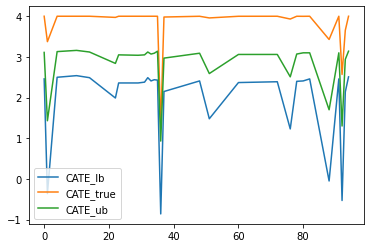

In [17]:
cate.loc[cate['CATE_true'] >= cate['CATE_ub'], ][['CATE_lb', 'CATE_true', 'CATE_ub']].plot()

In [9]:
coverage_df = pd.concat(coverage)
# coverage_agg[coverage_agg < 0.95]

## Check if bias corrected betting covers population CATE

In [1]:
!export PYTHONPATH=/usr/project/xtmp/sk787/variable_imp_matching/

In [2]:
import sys
sys.path.append('/usr/project/xtmp/sk787/variable_imp_matching/')
sys.path.insert(0, '/usr/project/xtmp/sk787/variable_imp_matching/')

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from datagen.dgp_df import dgp_poly_basic_df, dgp_df
from src.variable_imp_matching import VIM
from scipy.spatial.distance import pdist
import warnings
from utils import save_df_to_csv
from collections import namedtuple
from argparse import ArgumentParser
from econml.dml import CausalForestDML, KernelDML
from econml.dr import DRLearner
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor

from bias_corr_betting import calib_bias, get_CATE_bias_betting_bound

from variance_playground import *

In [41]:
n_est = 10000
coverage_list = []
for k in [10, 30, 60, 100, 300]:
    df_train_sub, df_calib, df_est, cate, query_x = check_variance(dgp = 'lihua_uncorr_hetero', n_train = 10000, n_est = n_est, n_imp = 2, n_unimp = 100, k = k, seed = 0, fit = 'bias_corr_betting_ensemble')
    coverage_list.append( cate['contains_true_cate'].mean() )

Trying to find data.
Files not found. Recreating...
Calib treatment: [1 0]
k 65
291: query_x is None: False
cate nrow: 100
df_est nrow: 10000
df_train nrow: 10001


Model fit to treatment=0 had all zero weights.


y_min -7.258096538021482
y_max 7.258096538021482
Sq Error 1.2329953806931035
Coverage 0.88
1/2 width: 2.7011063793268146


In [6]:
n_est = 10000
df_train_sub, df_calib, df_est, cate, query_x = check_variance(dgp = 'lihua_uncorr_hetero', n_train = 10000, n_est = n_est, n_imp = 2, n_unimp = 100, k = int(np.sqrt(n_est)), seed = 0, fit = 'bias_corr_betting_ensemble')

Trying to find data.


Found data. Read in...
k 100
291: query_x is None: False
cate nrow: 100
df_est nrow: 10000
df_train nrow: 10001
y_min -7.258096538021482
y_max 7.258096538021482
Sq Error 1.2316052808025397
Coverage 0.88
1/2 width: 2.3321038302040966


In [33]:
dgp = 'lihua_uncorr_hetero'
n_train = 10000
n_est = 10000
n_imp = 2
n_unimp = 100
seed = 0
k = int(np.sqrt(n_est))
fit = 'bias_corr_betting_ensemble'

In [34]:
# ## make data
# # df_train, df_est, df_true, x_cols = dgp_poly_basic_df(n_samples, n_imp, n_unimp, powers=[2], perc_train=None, n_train=None)
# query_x, query_x_true = get_est_set(dgp, n_imp, n_unimp)
# # query_x_true = query_x['CATE_true']
# # query_x = query_x.drop('CATE_true', axis = 1)

# np.random.seed(seed)
# # df_train, df_est, df_true, x_cols, discrete = dgp_df(dgp = dgp, n_samples = n_train + n_est, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=n_train)

# ## split into train, calibrate, and estimation
# # df_train_sub, df_calib = train_test_split(df_train, test_size = 0.4, stratify = df_train['T'].values, random_state = 42)
# # print('Calib treatment:', df_calib['T'].unique())

# df_train_sub, df_calib, df_est, x_cols, ymin, ymax = get_data(dgp, n_train, n_est, n_imp, n_unimp, k, seed)
# df_train = pd.concat([df_train_sub, df_calib], axis = 0)

# if fit == 'gen_data':
#     print('Done generating data.')
#     exit()

# lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
# if fit == 'vim':
#     lcm.fit(return_scores = False)
# elif fit == 'vim_tree':
#     lcm.fit(return_scores = False, model = 'tree')
# elif fit == 'vim_ensemble':
#     lcm.fit(return_scores = False, model = 'ensemble')
# elif fit == 'nn_vim':
#     lcm.M = np.ones(len(x_cols))
# else:
#     lcm.M = np.ones(len(x_cols))
# # else:
# #     raise ValueError('oops. fit should be either vim or nn or nn_mml.')

# print('k', k)
# mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est, k=k, return_original_idx=False, query_x = query_x)
# cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x)
# cate['CATE_true'] = query_x_true

print('cate nrow:', cate.shape[0])
print('df_est nrow:', df_est.shape[0])
print('df_train nrow:', df_train.shape[0])

# estimate CATE
baseline_df_train = pd.concat([df_train, df_est])
if fit == 'causal_forest':
    estimator = CausalForestDML()
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'auto'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 'kernel_dml':
    estimator = KernelDML()
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'bootstrap'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 'dr_learner':
    estimator = DRLearner()
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'auto'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 'x_learner':
    estimator = XLearner(models = RandomForestRegressor())
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'bootstrap'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 's_learner':
    estimator = SLearner(overall_model = RandomForestRegressor())
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'bootstrap'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 't_learner':
    estimator = TLearner(models = RandomForestRegressor())
    CATE_mean, lb, ub = get_method_CATE_error_bound(df_train = baseline_df_train, df_est = query_x, treatment_col = 'T', outcome_col = 'Y', alpha = 0.05, estimator = estimator, fit_params = {'inference' : 'bootstrap'})
    cate['CATE_mean'] = CATE_mean
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 'nn_mml':
    d = n_imp + n_unimp
    k_n = int(df_est.shape[0]**(2/(2 + d)) * (df_est['T'].mean()))
    cate['CATE_error_bound'] = get_mml_CATE_error_bound(df_est = df_est, treatment_col = 'T', outcome_col = 'Y', mgs = mgs, alpha = 0.05, T = 1, C = 0)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'naive':
    cate['CATE_error_bound'] = (df_est['Y'].max() - df_est['Y'].min())/2
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'prog_boost_vim':
    # fit gradient boosting trees to find prognostic score
    
    gbt = GradientBoostingRegressor()
    gbt.fit(df_train_sub.loc[df_train_sub['T'] == 0, ].drop(['T', 'Y'], axis =1), y = df_train_sub.loc[df_train_sub['T'] == 0, ]['Y'].values)
    df_calib['prog'] = gbt.predict(df_calib.drop(['T', 'Y'], axis = 1))
    df_est['prog'] = gbt.predict(df_est.drop(['T', 'Y'], axis = 1))
    query_x['prog'] = gbt.predict(query_x.drop(['T', 'Y'], axis = 1))

    # do VIM on top of prognostic score
    lcm = VIM(outcome = 'Y', treatment = 'T', data = df_calib[['prog', 'T', 'Y']], binary_outcome=False, random_state=None)
    lcm.fit(return_scores = True)
    lcm.M = np.ones(lcm.M.shape[0])
    
    # calibrate distances
    mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est[['prog', 'T', 'Y']], k=k, return_original_idx=False, query_x = query_x[['prog']])
    cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x[['prog']])
    cate['CATE_true'] = query_x_true
    
    model_dict = estimate_calibration_distance(df_calib[['prog', 'T', 'Y']], treatment_col = 'T', outcome_col = 'Y', M = [1], metric = 'cityblock')
    cate['CATE_error_bound'] = get_CATE_error_bound(mgs_dists[1], mgs_dists[0], k = k, model_dict = model_dict, T = 1, C = 0, min_y = df_train['Y'].min(), max_y = df_train['Y'].max(), alpha = 0.05)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'prog_cf_vim':
    # fit gradient boosting trees to find prognostic score
    
    cf = CausalForestDML()
    cf.fit(X = df_train_sub.drop(['T', 'Y'], axis =1), T = df_train_sub['T'].values, Y = df_train_sub['Y'].values)
    df_calib['prog'] = cf.effect(df_calib.drop(['T', 'Y'], axis = 1))
    df_est['prog'] = cf.effect(df_est.drop(['T', 'Y'], axis = 1))
    query_x['prog'] = cf.effect(query_x.drop(['T', 'Y'], axis = 1))

    # do VIM on top of prognostic score
    lcm = VIM(outcome = 'Y', treatment = 'T', data = df_calib[['prog', 'T', 'Y']], binary_outcome=False, random_state=None)
    lcm.fit(return_scores = True)
    lcm.M = np.ones(lcm.M.shape[0])
    
    # calibrate distances
    mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est[['prog', 'T', 'Y']], k=k, return_original_idx=False, query_x = query_x[['prog']])
    cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x[['prog']])
    cate['CATE_true'] = query_x_true
    
    model_dict = estimate_calibration_distance(df_calib[['prog', 'T', 'Y']], treatment_col = 'T', outcome_col = 'Y', M = [1], metric = 'cityblock')
    cate['CATE_error_bound'] = get_CATE_error_bound(mgs_dists[1], mgs_dists[0], k = k, model_dict = model_dict, T = 1, C = 0, min_y = df_train['Y'].min(), max_y = df_train['Y'].max(), alpha = 0.05)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif 'vim' in fit:
    model_dict = estimate_calibration_distance(df_calib, treatment_col = 'T', outcome_col = 'Y', M = lcm.M, metric = 'cityblock')
    cate['CATE_error_bound'] = get_CATE_error_bound(mgs_dists[1], mgs_dists[0], k = k, model_dict = model_dict, T = 1, C = 0,  min_y = df_train['Y'].min(), max_y = df_train['Y'].max(), alpha = 0.05)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'bias_corr':
    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = RandomForestRegressor, T = 1, C = 0, args = {})

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}

    cate['CATE_error_bound'] = get_CATE_bias_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, min_y = df_train['Y'].min(), max_y = df_train['Y'].max(), alpha = 0.05)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'boost_bias_corr':
    
    lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
    lcm.fit(return_scores = False, model = 'ensemble')

    mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est, k=k, return_original_idx=False, query_x = query_x)
    cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x)
    cate['CATE_true'] = query_x_true
    
    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = RandomForestRegressor, T = 1, C = 0, args = {})

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}

    cate['CATE_error_bound'] = get_CATE_bias_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, min_y = df_train['Y'].min(), max_y = df_train['Y'].max(), alpha = 0.05)
    cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
    cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
elif fit == 'bias_corr_betting':
    lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
    lcm.fit(return_scores = False, model = 'linear')

    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = RandomForestRegressor, T = 1, C = 0)

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    
    lb, ub = get_CATE_bias_betting_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, df_est = df_est, Y = 'Y', tx = 'T', mgs = mgs, ymin = ymin, ymax = ymax, alpha = 0.05)
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
elif fit == 'bias_corr_betting_ensemble':
    lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
    lcm.fit(return_scores = False, model = 'ensemble')

    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = RandomForestRegressor, T = 1, C = 0)

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    
    lb, ub = get_CATE_bias_betting_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, df_est = df_est, Y = 'Y', tx = 'T', mgs = mgs, ymin = ymin, ymax = ymax, alpha = 0.05)
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
else:
    raise ValueError('fit nor recognized')
# cate['CATE_lb'] = cate['CATE_mean'] - cate['CATE_error_bound']
# cate['CATE_ub'] = cate['CATE_mean'] + cate['CATE_error_bound']
cate['contains_true_cate'] = (cate['CATE_lb'] <= cate['CATE_true']) * (cate['CATE_ub'] >= cate['CATE_true'])
cate['se'] = ((cate['CATE_true'] - cate['CATE_mean'])**2)

cate['fit'] = fit
cate['seed'] = seed
cate['dgp'] = dgp
cate['n_train'] = n_train
cate['n_est'] = n_est
cate['CATE_full_width'] = cate['CATE_ub'] - cate['CATE_lb']

# print('Sq Error', cate['se'].mean())
# print('Coverage', cate['contains_true_cate'].mean())
# print('1/2 width:', cate['CATE_full_width'].mean())

cate nrow: 100
df_est nrow: 10000
df_train nrow: 10001
y_min -7.258096538021482
y_max 7.258096538021482


### Appendix: Check if ramdas actually covers the mean

In [7]:
from confseq.betting import betting_ci, hedged_cs
import numpy as np
import pandas as pd
true_mean = 5
coverage_betting = []
coverage_betting_est = []
coverage_hedged = []

betting_lb_list = []
betting_ub_list = []

betting_est_lb_list = []
betting_est_ub_list = []

hedged_lb_list = []
hedged_ub_list = []

def normalize_samples(samples, min, max):
    return (samples - min)/(max - min)

def unnormalize_samples(samples, min, max):
    return samples * (max - min) + min

def make_betting_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max() 
    
    samples_normalized = normalize_samples(samples, min, max) # (samples - y_min)/(y_max - y_min)

    betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    betting_lb = betting_cs_result[0]
    betting_ub = betting_cs_result[1]

    betting_lb = unnormalize_samples(betting_lb, min, max) # betting_lb * (y_max - y_min) + y_min
    betting_ub = unnormalize_samples(betting_ub, min, max) # betting_ub * (y_max - y_min) + y_min
    
    return betting_lb, betting_ub

def make_hedged_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max()

    samples_normalized = normalize_samples(samples, min, max)

    hedged_cs_result = hedged_cs(samples_normalized, alpha = alpha)

    hedged_lb = hedged_cs_result[0][-1]
    hedged_ub = hedged_cs_result[1][-1]
    hedged_lb = unnormalize_samples(hedged_lb, min, max) #hedged_lb * (y_max - y_min) + y_min
    hedged_ub = unnormalize_samples(hedged_ub, min, max) #hedged_ub * (y_max - y_min) + y_min
    
    return hedged_lb, hedged_ub


for seed in range(500):
    seed *= 42
    np.random.seed(seed)
    samples_a = np.random.uniform(true_mean - 10, true_mean, size = 10)
    samples_b = np.random.uniform(true_mean - 5, true_mean + 5, size = 10)
    samples_c = np.random.uniform(true_mean, true_mean + 10, size = 10)
    samples = np.concatenate([samples_a, samples_b, samples_c])
    
    betting_est_lb, betting_est_ub = make_betting_ci(samples, alpha = 0.05, min = samples.min(), max = samples.max())
    betting_est_lb_list.append(betting_est_lb)
    betting_est_ub_list.append(betting_est_ub)
    coverage_betting_est.append((betting_est_lb <= true_mean) * (true_mean <= betting_est_ub))

    

    betting_lb, betting_ub = make_betting_ci(samples, alpha = 0.05, min = true_mean - 10, max = true_mean + 10)
    betting_lb_list.append(betting_lb)
    betting_ub_list.append(betting_ub)
    coverage_betting.append((betting_lb <= true_mean) * (true_mean <= betting_ub))

    # hedged_lb, hedged_ub = make_hedged_ci(samples, alpha = 0.05, min = true_mean - 10, max = true_mean + 10)
    # hedged_lb_list.append(hedged_lb)
    # hedged_ub_list.append(hedged_ub)
    # coverage_hedged.append((hedged_lb <= true_mean) * (true_mean <= hedged_ub))

In [8]:
print('Hedged coverage:', np.mean(coverage_betting_est))
print('Betting coverage:', np.mean(coverage_betting))

Hedged coverage: 0.976
Betting coverage: 0.998


<AxesSubplot:>

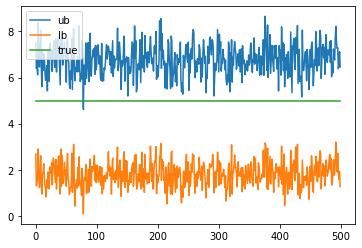

In [6]:
pd.DataFrame({'ub' : betting_ub_list, 'lb' : betting_lb_list, 'true' : true_mean}).plot()